<a href="https://colab.research.google.com/github/pankaja0285/era_v1_session8_pankaja/blob/main/CiFAR_S8_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NOTE: If running from colab and you have uploaded the folder ERA-V1/era_v1_session8_pankaja then uncomment the two cells below and run before moving on to Install libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# %cd /gdrive/My\ Drive/ERA-V1/era_v1_session8_pankaja
current_path = "/content/drive/MyDrive/ERA_V1/era_v1_session8_pankaja"
current_path

'/content/drive/MyDrive/ERA_V1/era_v1_session8_pankaja'

In [3]:
import os
os.chdir(current_path)
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1bgfAWXoB_B4tVOjl87ebjLopidZ60n2W/era_v1_session8_pankaja'

### Target:
Apply:
 - Batch Normalization
 - Group Normalization
 - Linear Normalization


# Install libraries

In [4]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-d1lkdmyh
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-d1lkdmyh
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=fcdab3eaddd9c5645d03ef5a08cbc3f2c22d8ecb8ded3c5ecf83815ccd41cd2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ytpxyyi/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


# Import Libraries

Let's first import all the necessary libraries

In [4]:
from __future__ import print_function
import numpy as np
from utils import plot_metrics, train, test, helper
from models import model
import torch
import torch.nn as nn
from pprint import pprint

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

import torchvision
from torchsummary import summary
from dataloader.load_data import CIFAR10DataLoader
from utils.engine import TriggerEngine

In [5]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1bgfAWXoB_B4tVOjl87ebjLopidZ60n2W/era_v1_session8_pankaja'

In [6]:
os.listdir()

['.gitignore',
 'README.md',
 'S8_sub.ipynb',
 'utils',
 'dataloader',
 'data_analysis',
 'models',
 'config',
 'data',
 'S8.ipynb',
 'runs']

## Load Configuration

In [7]:
config = helper.process_config("./config/config.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'args': {'cutout_prob': 0.5,
                                'horizontalflip_prob': 0.2,
                                'num_holes': 1,
                                'rotate_limit': 15,
                                'shiftscalerotate_prob': 0.25},
                       'type': 'CIFAR10Albumentation'},
 'data_loader': {'args': {'batch_size': 256,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'CIFAR10DataLoader'},
 'model': 'cifar10',
 'model_params

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [9]:
# BN - Model summary
model_bn = model.Net1().to(device)
summary(model_bn, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

## Download and view sample images

In [12]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
config['data_augmentation']['type'] = "CIFAR10Albumentation"
trigger_training=TriggerEngine(config)

Files already downloaded and verified
Files already downloaded and verified


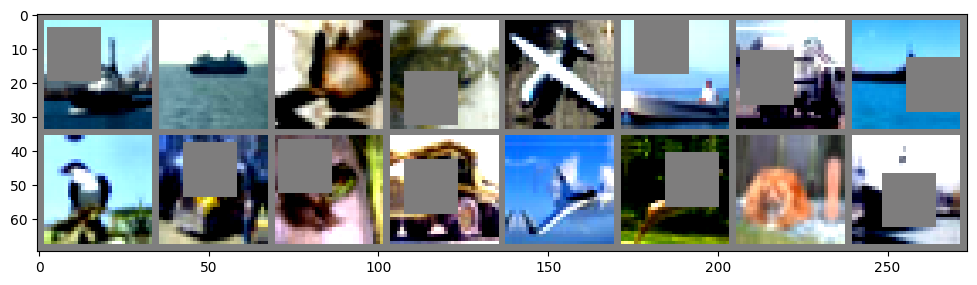

In [13]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader, test_loader = trigger_training.dataloader()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

In [14]:
torch.manual_seed(1)
# batch_size = 128
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)

CUDA Available? True


### With Batch Normalization

**Apply: Batch Normalization**

#### Train & Test our Model with Batch Normalization
 Let's train and test our model

In [36]:
if not os.path.exists("saved_models"):
    os.makedirs("saved_models", mode=0o777)

In [37]:
exp_metrics_bn={}
config['model_params']['experiment_name'] = 'CiFar_Model_BN'
experiment_name_bn = config['model_params']['experiment_name']

config['model_params']['model_for'] = 'bn'
config['model_params']['model_name'] = 'CiFar_Model_BN'
config['model_params']['save_model'] = 'Y'
config['training_params']['epochs'] = 45

#Get dataloaders
train_loader, test_loader = trigger_training.dataloader()

trigger_training_bn = TriggerEngine(config)

# trigger_training
(exp_metrics_bn[experiment_name_bn]) = trigger_training_bn.run_experiment(model_bn, train_loader, test_loader)
trigger_training.save_experiment(model_bn, experiment_name_bn, path="saved_models")


Files already downloaded and verified
Files already downloaded and verified
Net1(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

Loss=0.6097690463066101 Batch_id=195 LR=0.00053 Accuracy=76.43: 100%|██████████| 196/196 [00:20<00:00,  9.41it/s]



Test set: Average loss: 0.0020, Accuracy: 8338/10000 (83.38%)

Epoch 2:


Loss=0.6283110976219177 Batch_id=195 LR=0.00091 Accuracy=76.09: 100%|██████████| 196/196 [00:19<00:00, 10.12it/s]



Test set: Average loss: 0.0020, Accuracy: 8332/10000 (83.32%)

Epoch 3:


Loss=0.5820556282997131 Batch_id=195 LR=0.00152 Accuracy=76.30: 100%|██████████| 196/196 [00:20<00:00,  9.36it/s]



Test set: Average loss: 0.0020, Accuracy: 8249/10000 (82.49%)

Epoch 4:


Loss=0.5808342695236206 Batch_id=195 LR=0.00233 Accuracy=75.77: 100%|██████████| 196/196 [00:18<00:00, 10.34it/s]



Test set: Average loss: 0.0021, Accuracy: 8239/10000 (82.39%)

Epoch 5:


Loss=0.6280723810195923 Batch_id=195 LR=0.00330 Accuracy=74.37: 100%|██████████| 196/196 [00:21<00:00,  9.26it/s]



Test set: Average loss: 0.0022, Accuracy: 8123/10000 (81.23%)

Epoch 6:


Loss=1.007146954536438 Batch_id=195 LR=0.00437 Accuracy=73.77: 100%|██████████| 196/196 [00:19<00:00, 10.23it/s]



Test set: Average loss: 0.0024, Accuracy: 7980/10000 (79.80%)

Epoch 7:


Loss=0.7651762962341309 Batch_id=195 LR=0.00548 Accuracy=72.81: 100%|██████████| 196/196 [00:20<00:00,  9.34it/s]



Test set: Average loss: 0.0024, Accuracy: 7945/10000 (79.45%)

Epoch 8:


Loss=0.761449933052063 Batch_id=195 LR=0.00658 Accuracy=72.22: 100%|██████████| 196/196 [00:20<00:00,  9.43it/s]



Test set: Average loss: 0.0023, Accuracy: 8005/10000 (80.05%)

Epoch 9:


Loss=0.7658554315567017 Batch_id=195 LR=0.00760 Accuracy=71.43: 100%|██████████| 196/196 [00:20<00:00,  9.47it/s]



Test set: Average loss: 0.0028, Accuracy: 7554/10000 (75.54%)

Epoch 10:


Loss=0.8963603973388672 Batch_id=195 LR=0.00850 Accuracy=70.90: 100%|██████████| 196/196 [00:19<00:00, 10.24it/s]



Test set: Average loss: 0.0024, Accuracy: 7899/10000 (78.99%)

Epoch 11:


Loss=0.9909683465957642 Batch_id=195 LR=0.00921 Accuracy=70.38: 100%|██████████| 196/196 [00:20<00:00,  9.46it/s]



Test set: Average loss: 0.0027, Accuracy: 7684/10000 (76.84%)

Epoch 12:


Loss=0.8034111857414246 Batch_id=195 LR=0.00971 Accuracy=69.97: 100%|██████████| 196/196 [00:19<00:00, 10.16it/s]



Test set: Average loss: 0.0033, Accuracy: 7289/10000 (72.89%)

Epoch 13:


Loss=1.0097875595092773 Batch_id=195 LR=0.00997 Accuracy=69.99: 100%|██████████| 196/196 [00:20<00:00,  9.66it/s]



Test set: Average loss: 0.0026, Accuracy: 7751/10000 (77.51%)

Epoch 14:


Loss=1.0350931882858276 Batch_id=195 LR=0.00999 Accuracy=69.95: 100%|██████████| 196/196 [00:19<00:00, 10.23it/s]



Test set: Average loss: 0.0026, Accuracy: 7760/10000 (77.60%)

Epoch 15:


Loss=0.6703134775161743 Batch_id=195 LR=0.00994 Accuracy=69.98: 100%|██████████| 196/196 [00:20<00:00,  9.39it/s]



Test set: Average loss: 0.0025, Accuracy: 7771/10000 (77.71%)

Epoch 16:


Loss=0.7961365580558777 Batch_id=195 LR=0.00984 Accuracy=70.29: 100%|██████████| 196/196 [00:21<00:00,  9.17it/s]



Test set: Average loss: 0.0028, Accuracy: 7690/10000 (76.90%)

Epoch 17:


Loss=1.0231497287750244 Batch_id=195 LR=0.00970 Accuracy=70.26: 100%|██████████| 196/196 [00:20<00:00,  9.38it/s]



Test set: Average loss: 0.0028, Accuracy: 7697/10000 (76.97%)

Epoch 18:


Loss=0.9452298283576965 Batch_id=195 LR=0.00950 Accuracy=70.21: 100%|██████████| 196/196 [00:19<00:00, 10.08it/s]



Test set: Average loss: 0.0027, Accuracy: 7669/10000 (76.69%)

Epoch 19:


Loss=0.9329501986503601 Batch_id=195 LR=0.00927 Accuracy=70.07: 100%|██████████| 196/196 [00:21<00:00,  9.16it/s]



Test set: Average loss: 0.0028, Accuracy: 7664/10000 (76.64%)

Epoch 20:


Loss=0.8840479850769043 Batch_id=195 LR=0.00898 Accuracy=70.51: 100%|██████████| 196/196 [00:19<00:00, 10.23it/s]



Test set: Average loss: 0.0026, Accuracy: 7793/10000 (77.93%)

Epoch 21:


Loss=0.6439275741577148 Batch_id=195 LR=0.00866 Accuracy=70.62: 100%|██████████| 196/196 [00:20<00:00,  9.47it/s]



Test set: Average loss: 0.0025, Accuracy: 7906/10000 (79.06%)

Epoch 22:


Loss=1.1255981922149658 Batch_id=195 LR=0.00831 Accuracy=71.00: 100%|██████████| 196/196 [00:19<00:00, 10.10it/s]



Test set: Average loss: 0.0026, Accuracy: 7762/10000 (77.62%)

Epoch 23:


Loss=0.7408292293548584 Batch_id=195 LR=0.00792 Accuracy=70.99: 100%|██████████| 196/196 [00:21<00:00,  9.32it/s]



Test set: Average loss: 0.0026, Accuracy: 7781/10000 (77.81%)

Epoch 24:


Loss=0.8493816256523132 Batch_id=195 LR=0.00750 Accuracy=71.16: 100%|██████████| 196/196 [00:21<00:00,  9.23it/s]



Test set: Average loss: 0.0027, Accuracy: 7694/10000 (76.94%)

Epoch 25:


Loss=0.8382927775382996 Batch_id=195 LR=0.00705 Accuracy=71.50: 100%|██████████| 196/196 [00:19<00:00, 10.16it/s]



Test set: Average loss: 0.0026, Accuracy: 7780/10000 (77.80%)

Epoch 26:


Loss=0.8828974962234497 Batch_id=195 LR=0.00659 Accuracy=71.73: 100%|██████████| 196/196 [00:19<00:00, 10.22it/s]



Test set: Average loss: 0.0025, Accuracy: 7847/10000 (78.47%)

Epoch 27:


Loss=0.7359728813171387 Batch_id=195 LR=0.00611 Accuracy=71.93: 100%|██████████| 196/196 [00:19<00:00, 10.02it/s]



Test set: Average loss: 0.0026, Accuracy: 7757/10000 (77.57%)

Epoch 28:


Loss=0.8740133047103882 Batch_id=195 LR=0.00562 Accuracy=72.33: 100%|██████████| 196/196 [00:19<00:00, 10.19it/s]



Test set: Average loss: 0.0026, Accuracy: 7789/10000 (77.89%)

Epoch 29:


Loss=0.6682823300361633 Batch_id=195 LR=0.00512 Accuracy=72.56: 100%|██████████| 196/196 [00:19<00:00, 10.23it/s]



Test set: Average loss: 0.0024, Accuracy: 7929/10000 (79.29%)

Epoch 30:


Loss=0.7895833849906921 Batch_id=195 LR=0.00462 Accuracy=72.90: 100%|██████████| 196/196 [00:19<00:00, 10.20it/s]



Test set: Average loss: 0.0024, Accuracy: 7920/10000 (79.20%)

Epoch 31:


Loss=0.6499736905097961 Batch_id=195 LR=0.00413 Accuracy=73.47: 100%|██████████| 196/196 [00:19<00:00, 10.24it/s]



Test set: Average loss: 0.0023, Accuracy: 8017/10000 (80.17%)

Epoch 32:


Loss=0.9452247619628906 Batch_id=195 LR=0.00364 Accuracy=73.55: 100%|██████████| 196/196 [00:21<00:00,  8.93it/s]



Test set: Average loss: 0.0023, Accuracy: 8034/10000 (80.34%)

Epoch 33:


Loss=0.8617781400680542 Batch_id=195 LR=0.00317 Accuracy=74.08: 100%|██████████| 196/196 [00:19<00:00, 10.26it/s]



Test set: Average loss: 0.0022, Accuracy: 8121/10000 (81.21%)

Epoch 34:


Loss=0.5454699993133545 Batch_id=195 LR=0.00272 Accuracy=74.54: 100%|██████████| 196/196 [00:21<00:00,  9.27it/s]



Test set: Average loss: 0.0021, Accuracy: 8209/10000 (82.09%)

Epoch 35:


Loss=0.7867605686187744 Batch_id=195 LR=0.00229 Accuracy=74.96: 100%|██████████| 196/196 [00:19<00:00, 10.17it/s]



Test set: Average loss: 0.0021, Accuracy: 8230/10000 (82.30%)

Epoch 36:


Loss=0.633192777633667 Batch_id=195 LR=0.00188 Accuracy=75.27: 100%|██████████| 196/196 [00:21<00:00,  9.19it/s]



Test set: Average loss: 0.0021, Accuracy: 8242/10000 (82.42%)

Epoch 37:


Loss=0.6012890338897705 Batch_id=195 LR=0.00151 Accuracy=75.78: 100%|██████████| 196/196 [00:19<00:00,  9.88it/s]



Test set: Average loss: 0.0021, Accuracy: 8259/10000 (82.59%)

Epoch 38:


Loss=0.7484688758850098 Batch_id=195 LR=0.00117 Accuracy=76.14: 100%|██████████| 196/196 [00:22<00:00,  8.88it/s]



Test set: Average loss: 0.0020, Accuracy: 8274/10000 (82.74%)

Epoch 39:


Loss=0.7521399855613708 Batch_id=195 LR=0.00087 Accuracy=76.55: 100%|██████████| 196/196 [00:19<00:00,  9.99it/s]



Test set: Average loss: 0.0020, Accuracy: 8300/10000 (83.00%)

Epoch 40:


Loss=0.6627009510993958 Batch_id=195 LR=0.00061 Accuracy=77.01: 100%|██████████| 196/196 [00:24<00:00,  8.11it/s]



Test set: Average loss: 0.0019, Accuracy: 8312/10000 (83.12%)

Epoch 41:


Loss=0.6568934917449951 Batch_id=195 LR=0.00039 Accuracy=77.38: 100%|██████████| 196/196 [00:20<00:00,  9.71it/s]



Test set: Average loss: 0.0019, Accuracy: 8355/10000 (83.55%)

Epoch 42:


Loss=0.7785035967826843 Batch_id=195 LR=0.00022 Accuracy=77.27: 100%|██████████| 196/196 [00:21<00:00,  9.15it/s]



Test set: Average loss: 0.0019, Accuracy: 8370/10000 (83.70%)

Epoch 43:


Loss=0.6240016222000122 Batch_id=195 LR=0.00010 Accuracy=77.67: 100%|██████████| 196/196 [00:20<00:00,  9.65it/s]



Test set: Average loss: 0.0019, Accuracy: 8379/10000 (83.79%)

Epoch 44:


Loss=0.7174460887908936 Batch_id=195 LR=0.00002 Accuracy=77.53: 100%|██████████| 196/196 [00:20<00:00,  9.33it/s]



Test set: Average loss: 0.0019, Accuracy: 8379/10000 (83.79%)

Epoch 45:


Loss=0.6577096581459045 Batch_id=195 LR=0.00000 Accuracy=77.69: 100%|██████████| 196/196 [00:19<00:00,  9.86it/s]



Test set: Average loss: 0.0019, Accuracy: 8375/10000 (83.75%)

Saving the model for CiFar_Model_BN


In [39]:
# Model summary
trigger_training.model_summary(model_bn, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           4,704
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           4,608
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

**Misclassification**

Total wrong predictions are 1625
Files already downloaded and verified


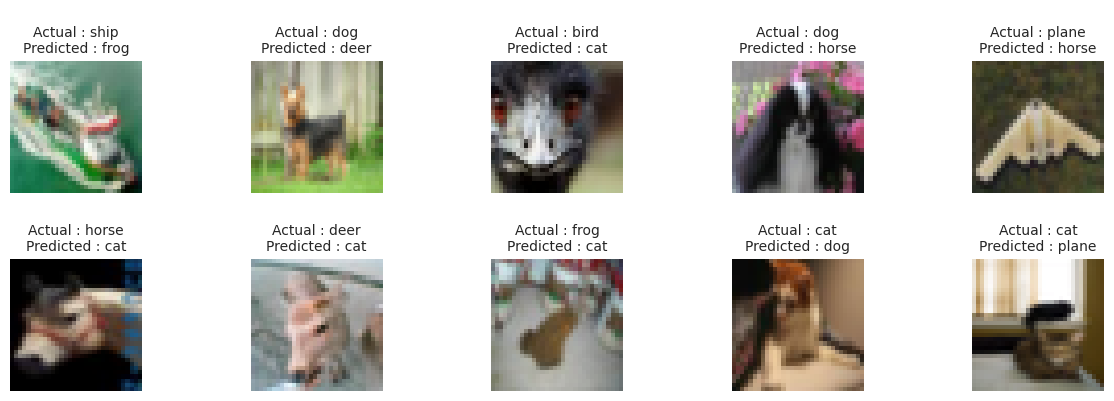

[(tensor([[[ 1.2334e+00,  6.6187e-01,  3.7612e-01,  ..., -2.5887e-01,
            -1.7949e-01, -6.8371e-02],
           [ 1.5509e+00,  1.0905e+00,  9.4761e-01,  ..., -3.0649e-01,
            -2.2712e-01, -1.4774e-01],
           [ 1.7413e+00,  1.6143e+00,  1.5191e+00,  ..., -3.6999e-01,
            -3.2237e-01, -2.4299e-01],
           ...,
           [-1.4812e+00, -1.5447e+00, -1.5447e+00,  ..., -1.3383e+00,
            -1.6558e+00, -1.8940e+00],
           [-1.4812e+00, -1.5606e+00, -1.6082e+00,  ..., -1.8781e+00,
            -1.9416e+00, -1.9257e+00],
           [-1.5765e+00, -1.6400e+00, -1.6717e+00,  ..., -1.9257e+00,
            -1.9892e+00, -1.9575e+00]],
  
          [[ 1.6114e+00,  1.1604e+00,  1.0155e+00,  ...,  4.3566e-01,
             5.1619e-01,  6.2893e-01],
           [ 1.8530e+00,  1.4503e+00,  1.3859e+00,  ...,  4.0345e-01,
             4.8398e-01,  5.4840e-01],
           [ 2.0140e+00,  1.8530e+00,  1.7725e+00,  ...,  3.3902e-01,
             3.8734e-01,  4.5177e-01],

In [40]:
model_bn_mc = torch.load(f'./saved_models/{experiment_name_bn}.pt')
model_bn_mc.eval()
trigger_training.wrong_predictions(model_bn_mc, test_loader, num_img=10)


**Plot the train and test losses and accuracies for model_bn**

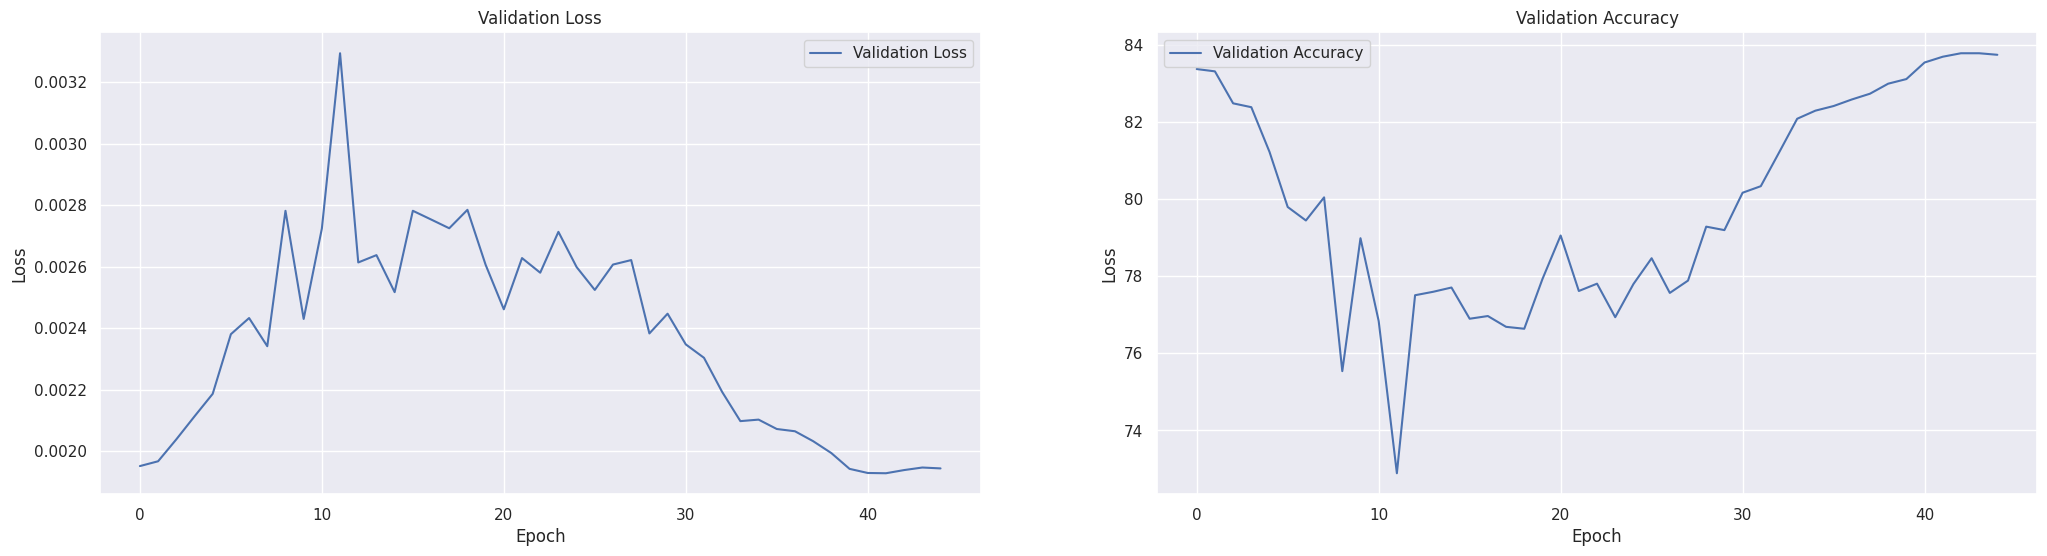

In [41]:
plot_metrics.plot_metrics(exp_metrics_bn[experiment_name_bn])
